# ABT Construction


#### First, let's import libraries we'll need for data cleaning and feature engineering.

In general, it's good practice to keep all of your library imports at the top of your notebook or program. **Tip:** If you forget one, you can always add it here later and re-run this code block.

We've provided comments for guidance.

In [142]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('darkgrid')

# (Optional) Suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Next, read in the dataset.
* The file name is <code style="color:crimson">'employee_data.csv'</code>

In [144]:
df = pd.read_csv('employee_data.csv')
print(df.shape)
df.head()

(14249, 10)


,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0


## Drop Unwanted Observations</span>

The first step to data cleaning is removing samples from your dataset that you don't want to include in the model.

#### A.) First, <span style="color:royalblue">drop duplicates</span> from the dataset.
* Then, print the shape of the new dataframe.

In [146]:
df=df.drop_duplicates()
df.shape

(14221, 10)

Did we have any duplicates in the dataset? (Did the number of observations decrease after calling the drop duplicates function?)


Next, let's drop any observations that are irrelevant to what we're trying to model. If you remember from the previous module, we saw that we have temp workers (based on the <code style="color:steelblue">'department'</code> feature). However, based on our **project scope**, we don't want to model temp workers. Let's just double-check.

#### B.) Display all of the unique classes of the <code style="color:steelblue">'department'</code> feature.

In [149]:
df.department.unique()

array(['engineering', 'support', 'sales', 'IT', 'product', 'marketing',
       'temp', 'procurement', 'finance', nan, 'management',
       'information_technology', 'admin'], dtype=object)

Ignoring the <span style="color:crimson">nan</span> for now, we can see that <span style="color:crimson">'temp'</span> shouldn't belong in this dataset! After all, based on the project scope, we're only trying to build a model for **permanent, full time employees**. Therefore, we should remove observations that belong to the <span style="color:crimson">'temp'</span> department. We don't want to risk them throwing off our model.

#### C.) Drop all observations that belong to the <span style="color:crimson">'temp'</span> department.


In [151]:
df.drop(df[df.department=='temp'].index, inplace=True)
df.shape

(14068, 10)

## Fix Structural Errors</span>

The next bucket under data cleaning involves fixing structural errors, which arise during measurement, data transfer, or other types of "poor housekeeping."

First, let's handle any features that should be **indicator variables**. Remember, these are variables that **should** be either <code style="color:crimson">0</code> or <code style="color:crimson">1</code>. However, maybe they were saved under different logic.

For example, remember the <code style="color:steelblue">'filed_complaint'</code> and <code style="color:steelblue">'recently_promoted'</code> features? They only had values of <code style="color:crimson">1</code> and <code style="color:crimson">NaN</code>.

#### A.) Print the unique values of <code style="color:steelblue">'filed_complaint'</code> and <code style="color:steelblue">'recently_promoted'</code>.

In [153]:
print(df.filed_complaint.unique())
print(df.recently_promoted.unique())

[nan  1.]
[nan  1.]


Even though the <code style="color:crimson">NaN</code> values are "missing," they actually indicate employees who have not filed complaints or those who have not been recently promoted. Therefore, we should fill them in with the value <code style="color:crimson">0</code>, which will turn them into true indicator variables.

#### B.) Fill missing <code style="color:steelblue">'filed_complaint'</code> and <code style="color:steelblue">'recently_promoted'</code> values with <code style="color:crimson">0</code>.

In [156]:
df.filed_complaint.fillna(0, inplace=True)
df.recently_promoted.fillna(0, inplace=True)

Now the "missing" values have been filled, and we have true indicator variables.

#### C.) Print the unique values of <code style="color:steelblue">'filed_complaint'</code> and <code style="color:steelblue">'recently_promoted'</code> again, just as a quick sanity check.

In [158]:
print(df.filed_complaint.unique())
print(df.recently_promoted.unique())

[0. 1.]
[0. 1.]


Next, let's check for **typos**, **inconsistent capitalization**, or **mislabeled classes**. For example, if you remember from the previous module, we checked the class distributions for <code style="color:steelblue">'department'</code> and found out that <code style="color:crimson">'IT'</code> and <code style="color:crimson">'information_technology'</code> as labeled as separate classes when they really refer to the same department. Let's fix that.

#### D.) Replace any instances of <code style="color:crimson">'information_technology'</code> with <code style="color:crimson">'IT'</code> instead.
* Remember to do it **inplace**.
* Then, plot the **bar chart** for <code style="color:steelblue">'department'</code> to see its new distribution.

<Axes: xlabel='Count', ylabel='department'>

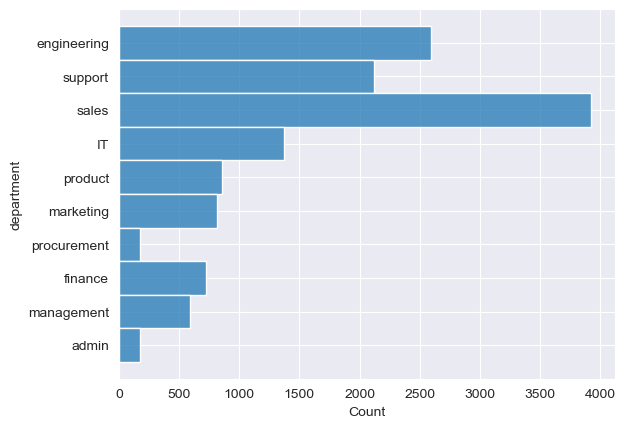

In [160]:
df['department'].replace('information_technology','IT', inplace=True)
sns.histplot(y=df.department)

Finally, let's consider if we need to remove any **unwanted outliers**. Well, here's another place where Exploratory Analysis helps us out a lot. We've already plotted the distributions for all of our features. 

And in this case, a simple eye-test is enough to tell us that it doesn't look like outliers will be a huge problem. Plus, because outliers are **innocent until proven guilty**, we don't have to spend too much time trying to chase them down. Let's check this off and move on to handling missing data.

## Handle Missing Data</span>

Next, it's time to handle **missing data**. Remember, the 2 most commonly recommended ways of dealing with missing data (dropping observations or imputing them) actually suck. Missing data is like missing a puzzle piece. If you drop it, that's like pretending the missing puzzle piece isn't there. If you impute it, that's like trying to squeeze in a piece from somewhere else in the puzzle.

Instead, we're going to be labeling missing values so our algorithm knows they were originally missing.

#### A.) First, let's pinpoint the missing data. Display the <span style="color:royalblue">number of missing values</span> for each feature (both categorical and numeric).

In [163]:
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1351
n_projects              0
recently_promoted       0
salary                  0
satisfaction            0
status                  0
tenure                  0
dtype: int64

**Note:** If you've been paying very close attention, you'll notice that in the previous module, <code>'satisfaction'</code> and <code>'tenure'</code> appeared to have missing values as well. As it turns out, those missing values belonged to temp workers, so we now have complete data for those two features after dropping temp workers from the dataset.

It looks like we have 1 categorical feature with missing data (<code style="color:steelblue">'department'</code>) and one numeric feature (<code style="color:steelblue">'last_evaluation'</code>). No problem. Remember, for categorical features, the strategy for dealing with them is **labeling them as missing**.

#### B.) Label missing values in <code style="color:steelblue">'department'</code> as <code style="color:crimson">'Missing'</code>.

In [166]:
df.department.fillna('Missing', inplace=True)

Next, let's **flag and fill** missing numerical features.

#### C.) First, let's flag <code style="color:steelblue">'last_evaluation'</code> with an indicator variable of missingness.
* <code style="color:crimson">0</code> if not missing.
* <code style="color:crimson">1</code> if missing. 

Let's name the new indicator variable <code style="color:steelblue">'last_evaluation_missing'</code>.
* We can use the <code style="color:steelblue">.isnull()</code> function.
* Also, remember to convert it with <code style="color:steelblue">.astype(int)</code>

In [168]:
df['last_evaluation_missing']=df['last_evaluation'].isnull().astype(int)

#### D.) Then, simply fill in the original missing value with <code style="color:crimson">0</code> just so your algorithms can run properly.

In [170]:
df['last_evaluation'].fillna(0, inplace=True)

Remember, by using this technique of flagging and filling, you are essentially **allowing the algorithm to estimate the optimal constant for missingness**, instead of just filling it in with the mean.

Now, our dataset should no longer have missing values.

#### E.) Display the number of missing values for each feature (both categorical and numeric) again, just to confirm.

In [172]:
df.isnull().sum()

avg_monthly_hrs            0
department                 0
filed_complaint            0
last_evaluation            0
n_projects                 0
recently_promoted          0
salary                     0
satisfaction               0
status                     0
tenure                     0
last_evaluation_missing    0
dtype: int64

## Engineer Features</span>

For this project, we're going to have an abbreviated version of feature engineering, since we've already covered many tactics in the previous project. Plus, since our dataset is larger, we don't really suffer from sparse classes as much. Instead, for this project, we want to highlight an elegant way good exploratory analysis translates to better feature engineering.

You see, we won't always have a lot of **domain knowledge** for the problem. In these situations, we should rely on exploratory analysis to provide us hints (a.k.a. "aha moments").

Do you remember the scatterplot of <code style="color:steelblue">'satisfaction'</code> and <code style="color:steelblue">'last_evaluation'</code> for employees who have <code style="color:crimson">'Left'</code>?

#### A.) Let's reproduce it here, just so we have it in front of us.

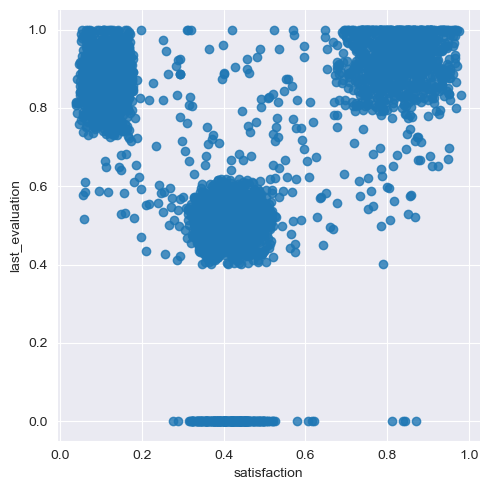

In [174]:
sns.lmplot(x='satisfaction',y='last_evaluation', data=df[df.status=='Left'], fit_reg=False)

Ah, that looks different from the one in the previous module! 
* Oh yes, it's because we just **flagged and filled** missing values for <code style="color:steelblue">'last_evaluation'</code> with 0.
* No problem, but let's ignore those observations for now and focus on the top half of the plot.

Based on the top half, it looks like there are 3 clusters of people who left.
1. First, we have people with high <code style="color:steelblue">'last_evaluation'</code> but low <code style="color:steelblue">'satisfaction'</code>. Maybe these people were overqualified, frustrated, or **unhappy** in some other way.
2. Next, we have people with low <code style="color:steelblue">'last_evaluation'</code> and medium <code style="color:steelblue">'satisfaction'</code>. These were probably **underperformers** or poor cultural fits.
3. Finally, we have people with high <code style="color:steelblue">'last_evaluation'</code> and high <code style="color:steelblue">'satisfaction'</code>. Perhaps these were **overachievers** who found better offers elsewhere.

These roughly translate to 3 **indicator features** we can engineer:

* <code style="color:steelblue">'underperformer'</code> - last_evaluation < 0.6 and last_evaluation_missing == 0
* <code style="color:steelblue">'unhappy'</code> - satisfaction_level < 0.2
* <code style="color:steelblue">'overachiever'</code> - last_evaluation > 0.8 and satisfaction > 0.7


#### B.) Create those 3 indicator features.
* Use boolean masks.
* **Important:** For <code style="color:steelblue">'underperformer'</code>, it's important to include <code style="color:steelblue">'last_evaluation_missing' == 0</code> to avoid those originally missing observations that we flagged and filled.

In [176]:
df['underperformer']=((df['last_evaluation']<0.6) & (df['last_evaluation_missing']==0)).astype(int)
df['unhappy']=(df['satisfaction']<0.2).astype(int)
df['overachiever']=((df['last_evaluation']>0.8) & (df['satisfaction']>0.7)).astype(int)

#### C.) Finally, check that you created the features correctly. Display the proportion of employees from the dataset that fall into each of those 3 categories.

In [178]:
df[['underperformer', 'unhappy', 'overachiever']].mean()

underperformer    0.285257
unhappy           0.092195
overachiever      0.177069
dtype: float64

## Save the ABT</span>

Finally, let's save the **analytical base table**. But before we do, we need to take care of 2 things.
1. First, we need to convert our target variable into an indicator variable.
2. Second, we need to convert other categorical features into dummy variables.

Scikit-Learn expects the target variable to be **numeric**. And since we only have 2 classes (<code style="color:crimson">'Left'</code> and <code style="color:crimson">'Employed'</code>), we can convert it into an indicator variable.

#### A.) Convert <code style="color:steelblue">'status'</code> into an indicator variable.
* <code style="color:crimson">'Left'</code> should be <code style="color:crimson">1</code>
* <code style="color:crimson">'Employed'</code> should be <code style="color:crimson">0</code>
* **Tip:** There's also a really easy way you can use <code style="color:steelblue">pd.get_dummies()</code> here. Try to see if you can discover it through trial-and-error and/or looking at the documentation. Otherwise, you can check the answer key.

In [180]:
df['status']=pd.get_dummies(df['status'])['Left'].astype(int)

#### B.) To confirm we did that correctly, display the proportion of people in our dataset who left.

In [182]:
df['status'].mean()

0.23933750355416547

Next, let's create dummy variables for the other categorical features.

#### C.) Overwrite your dataframe with a version that has <span style="color:royalblue">dummy variables</span> for the categorical features.
* Then, display the first 10 rows to confirm all of the changes we've made so far in this module.

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14068 entries, 0 to 14248
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avg_monthly_hrs          14068 non-null  int64  
 1   department               14068 non-null  object 
 2   filed_complaint          14068 non-null  float64
 3   last_evaluation          14068 non-null  float64
 4   n_projects               14068 non-null  int64  
 5   recently_promoted        14068 non-null  float64
 6   salary                   14068 non-null  object 
 7   satisfaction             14068 non-null  float64
 8   status                   14068 non-null  int32  
 9   tenure                   14068 non-null  float64
 10  last_evaluation_missing  14068 non-null  int32  
 11  underperformer           14068 non-null  int32  
 12  unhappy                  14068 non-null  int32  
 13  overachiever             14068 non-null  int32  
dtypes: float64(5), int32(5), in

In [185]:
df=pd.get_dummies(df, columns=['department','salary'],dtype=float)
df.head(10)

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,last_evaluation_missing,underperformer,unhappy,overachiever,department_IT,department_Missing,department_admin,department_engineering,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,140,0.0,0.589097,4,0.0,0.660020,0,4.0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,121,1.0,0.625399,3,0.0,0.835571,0,3.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,150,0.0,0.644586,4,0.0,0.796683,0,3.0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,215,1.0,0.524114,3,0.0,0.715005,0,7.0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,269,0.0,0.909364,5,0.0,0.994037,0,2.0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Finally, it doesn't look like we have any **unused or redundant features** in our augmented dataframe. Let's save this augmented dataframe.

#### D.) Save this dataframe as your <span style="color:royalblue">analytical base table</span> to use in later modules.
* Remember to set the argument <code style="color:steelblue">index=None</code> to save only the data.

In [187]:
df.to_csv('analytical base table.csv',index=None)


* You cleaned dropped irrelevant observations from the dataset.
* You fixed various structural errors, such as wannabe indicator variables.
* You handled missing data.
* You engineered features by leveraging your exploratory analysis.
* And you created dummy variables before saving the ABT.

